# Phase Calibration of RFSoC 23/5/15

Although the clocks in ADC and DAC are precise, they are not synchronized. 
Whether the ADC clock is advanced or retarded with respect to the DAC, it results in phase difference as a function of time

$$ \Delta \phi = 2\,\pi \,\tau\, f + \phi_0  $$

For phase coherent measurement, we need to figure out the ADC delay $\tau$ and compensate the effect of ADC delay!



In [1]:
# In[0] Phase cal.
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('Z:/Mingi Kim/python_codes/Experiment')
sys.path.append('Z:/Mingi Kim/FPGA/qick/qick_lib')
from qick import *
import LAB_v0 
import os
import time

Could not import QickSoc: No module named 'pynq'


import the RFSoC board

In [2]:
xilinx = LAB_v0.RFSoC()

Pyro.NameServer PYRO:Pyro.NameServer@192.168.0.102:8888
myqick PYRO:obj_dee286116b894fa0bf843023795fd247@192.168.0.102:35647

QICK configuration:

	Board: RFSoC4x2

	Global clocks (MHz): tProcessor 350.000, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, switch ch 0, maxlen 65536
		DAC tile 0, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz
	1:	axis_signal_gen_v6 - tProc output 1, switch ch 1, maxlen 65536
		DAC tile 2, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz

	2 readout channels:
	0:	ADC tile 0, ch 0, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 4, tProc input 0
	1:	ADC tile 0, ch 1, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 5, tProc input 1

	2 DACs:
		DAC tile 0, ch 0 is DAC_B
		DAC tile 2, ch 0 is DAC_A

	2 ADCs:
		ADC tile 0, ch 0 is ADC_D
		ADC tile 0, ch 1 is ADC_C

	4 digital output pins (tProc output 7):

initialize soc configurations and define several helper functions

In [5]:
'''
Phase calibration for gen ch=1, ro_ch = 0
'''

soccfg = xilinx.socconfig()[1]  # SoC configuration
soc = xilinx.socconfig()[0]   # SoC 

out_chs = [1]  # gen ch=1., ro_ch=0

def calculate_phase(d):
    [xi,xq] = d
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.mean(x)

    # Calculate calibration phase.
    fi = np.remainder(np.angle(xavg,deg=True)+360,360)
    return [fi, np.abs(xavg), np.std(x)]

def print_results(res, f0):
    print("freq_i = %f MHz, "%(f0) +
         "phi_i = (%.2f, %.2f) deg, " % tuple([res[i][0] for i in range(2)]) +
         "mag = (%.2f, %.2f), " % tuple([res[i][1] for i in range(2)]) +
         "RMS = (%.2f, %.2f) ADU" % tuple([res[i][2] for i in range(2)]))
#     print("freq_i = %f MHz, phi_i = (%.2f, %.2f) deg, mag = (%.2f, %.2f), RMS = (%.2f, %.2f) ADU" %(f0,*out_array,*A,*xrms))



I'll use the `SingleFreqProg` in the `LAB_v0.py` code

In [73]:

config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "res_phase":soccfg.deg2reg(0), # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 1400, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

res=[]
config['reps'] = 1


# change this from 1 to 50
config['soft_avgs'] = 50


f0_start=5000
f0_step=0.0007
expts=80

# =============================================================================
#f0_start=100
#f0_step=0.000250
#expts=40
# =============================================================================

f0_v = np.arange(0,expts)*f0_step+f0_start

f0_v = soccfg.adcfreq(f0_v, gen_ch=1, ro_ch=0)

# for f0 in [101]:
for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =LAB_v0.SingleFreqProgram(soccfg, config)
#     print(prog)
    data = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
#     print(data)
    res.append([calculate_phase(d) for d in data])
    print_results(res[-1], f0)
fi_v=np.array([[a[0] for a in r] for r in res]).T

soc.reset_gens()

freq_i = 5000.000002 MHz, phi_i = (358.76, 119.16) deg, mag = (35.04, 0.09), RMS = (4.14, 0.26) ADU
freq_i = 5000.000702 MHz, phi_i = (348.02, 101.34) deg, mag = (35.04, 0.08), RMS = (3.45, 0.28) ADU
freq_i = 5000.001402 MHz, phi_i = (337.34, 99.23) deg, mag = (35.10, 0.07), RMS = (4.14, 0.30) ADU
freq_i = 5000.002098 MHz, phi_i = (326.55, 81.56) deg, mag = (35.12, 0.08), RMS = (2.95, 0.26) ADU
freq_i = 5000.002798 MHz, phi_i = (315.84, 65.17) deg, mag = (35.18, 0.08), RMS = (5.42, 0.28) ADU
freq_i = 5000.003499 MHz, phi_i = (305.22, 57.43) deg, mag = (35.17, 0.08), RMS = (7.80, 0.26) ADU
freq_i = 5000.004199 MHz, phi_i = (294.31, 57.18) deg, mag = (35.24, 0.08), RMS = (2.10, 0.30) ADU
freq_i = 5000.004900 MHz, phi_i = (283.67, 38.31) deg, mag = (35.27, 0.08), RMS = (2.94, 0.26) ADU
freq_i = 5000.005600 MHz, phi_i = (272.99, 29.81) deg, mag = (35.18, 0.09), RMS = (4.14, 0.27) ADU
freq_i = 5000.006300 MHz, phi_i = (262.34, 12.52) deg, mag = (35.17, 0.08), RMS = (8.99, 0.28) ADU
freq_i =

Text(0.5, 0, '$f$ (MHz)')

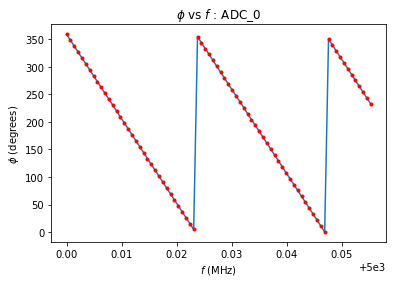

In [74]:
'''
Plot result
'''

plt.plot(f0_v, fi_v[0])
plt.plot(f0_v, fi_v[0], marker='.', linestyle="None", color='Red')
plt.title(r"$\phi$ vs $f$ : ADC_{}".format(0))
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")


Now we have frequency and corresponding data
which needed to be fit with $ (2\pi\,\tau\,f + \phi_0) + \phi_{signal} $

Let's define useful functions for analyzing phase and model function first

In [75]:

def phase_residuals(data,prediction):
    '''
    (data - pred + pi) mod 2pi ; returns the difference between data and pred
    '''
    r = np.remainder(data-prediction+180,360)-180
    return r
    
def phase_model(x, f0):
    '''
    x = [x0, x1] , 
    x0 : phase offset, x1 : ADC delay
    (x0 - 2pi*x1*f0) mod 2pi
    '''
    return np.remainder(x[0] - 360*x[1]*(f0), 360)

def phase_func(x, arg, freq):
    '''
    difference b/w data and phase drag due to the ADC delay = real signal
    '''
    resid = phase_residuals(arg, phase_model(x, freq))
    return resid

For fitting, we will estimate the slope (corresponds to ADC delay) and the intercept (offset phase)

In [76]:
from scipy.optimize import least_squares
#fig, axs = plt.subplots(2,1)

ch = 0

slopes = -1*(fi_v[ch,1:]-fi_v[ch,:-1])/(360*(f0_v[1:]-f0_v[:-1]))
print(slopes)


x0 = np.zeros(2)
x0[1] = np.median(slopes)
x0[0] = np.remainder(np.median(phase_residuals(fi_v[ch],phase_model(x0, f0_v))),360)
print("initial estimate: %.2f deg shift, %.2f us delay"% tuple(x0))

[   42.59789645    42.38626505    43.03690118    42.50519613
    42.12473507    43.27283083    42.16474623    42.38686933
    42.23568606    42.96351184    42.04536133    42.65382709
    42.51513961    42.97352956    42.70257368    41.3840832
    43.43427604    42.34422025    42.28621963    42.98979028
    43.16437569    42.47876848    42.1643729     42.54276491
    42.46108409    42.64820694    42.24575614    42.87648565
    41.82383124    42.90458524    42.51567346    43.07462881
    41.66166937 -1385.02648636    42.95586425    42.44736412
    42.24366042    42.72681868    42.49973328    42.93933559
    42.31716354    42.33231999    43.0137707     41.92708746
    42.38682151    42.75379247    43.03745336    42.06082392
    42.77948747    41.78035012    43.08896544    42.35709924
    42.3022356     43.11522991    42.08943911    42.19531729
    43.02183881    42.18686919    42.75331055    42.58757794
    42.60790247    42.29077438    41.80700853    43.41231574
    42.57420703    42.809

And then using `least_squares` method, will fit the linear function

In [77]:
# initial guess
x0

array([351.43571664,  42.50519613])

`least_squares(model , initial guess, maxfev, args=(ydata, xdata))`

by fitting, we will determine two parameters : $\tau$ and $\phi_0$

In [79]:
fit = least_squares(phase_func, x0, max_nfev=8000, args=(fi_v[ch], f0_v))
#     fit = least_squares(phase_func, x0, args=(fi_v[ch]), method='lm', x_scale='jac')
#     fit = least_squares(phase_func, x0, args=(fi_v[ch]), method='lm', x_scale=(1,1e-5))
fit.x[0] = np.remainder(fit.x[0], 360)
print(fit.status)
print("\nafter minimization: %.2f deg shift, %.2f us delay"% tuple(fit.x))

3

after minimization: 195.59 deg shift, 42.53 us delay


In [80]:
print(fit)

 active_mask: array([0., 0.])
        cost: 0.2884805301479766
         fun: array([ 9.30665571e-02,  7.59749865e-02,  1.12243357e-01, -1.47020436e-02,
       -8.42050534e-03,  9.37890360e-02, -9.34779455e-02, -1.35665379e-03,
        3.47593594e-02,  1.08994151e-01, -2.82319633e-04,  1.21940231e-01,
        9.07465181e-02,  9.45209460e-02, -1.72813428e-02, -6.04816227e-02,
        2.28473087e-01,  4.99920163e-04,  4.73693082e-02,  1.08862756e-01,
       -7.03944604e-03, -1.66960974e-01, -1.54016068e-01, -6.18006463e-02,
       -6.49915580e-02, -4.75877769e-02, -7.73644457e-02, -6.13729947e-03,
       -9.34713007e-02,  8.46070120e-02, -9.81191506e-03, -6.17209291e-03,
       -1.43465178e-01,  7.55000166e-02,  1.42391328e-02, -9.31090899e-02,
       -7.22460063e-02, -2.18544051e-05, -4.96193915e-02, -4.20105285e-02,
       -1.45191278e-01, -9.14999105e-02, -4.16300492e-02, -1.63578585e-01,
       -1.15349059e-02,  2.45931634e-02, -3.18054414e-02, -1.59725235e-01,
       -4.14013791e-02,

In [102]:
fit.x

array([195.59442516,  42.53010939])

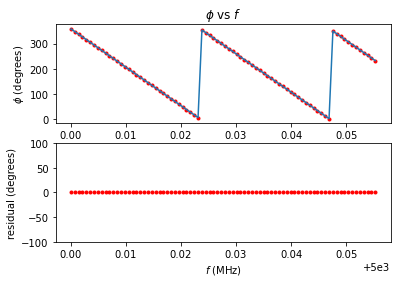

In [209]:
fig, axs = plt.subplots(2,1)

plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (degrees)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(f0_v,fi_v[ch], marker='.', linestyle="None",color="Red")
plot.plot(f0_v, phase_model(fit.x, f0_v))

plot = axs[1]
plot.set_ylabel(r"residual (degrees)")
plot.set_xlabel(r"$f$ (MHz)")
plot.set_ylim(-100,100)

plot.plot(f0_v, phase_func(fit.x, fi_v[ch], f0_v), marker='.', linestyle="None",color="Red")
#     plot.plot(f0_v, phase_func(x0, (fi_v[ch])), marker='.', linestyle="None",color="Red")



### initial guess instead of `least_square` fit

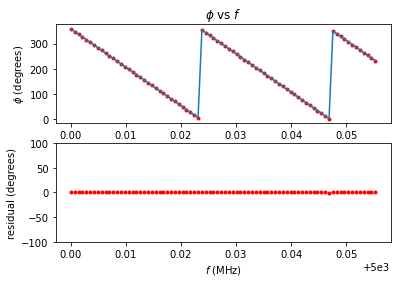

In [210]:
fig, axs = plt.subplots(2,1)

plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (degrees)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(f0_v,fi_v[ch], marker='.', linestyle="None",color="Red")
plot.plot(f0_v, phase_model(x0, f0_v))

plot = axs[1]
plot.set_ylabel(r"residual (degrees)")
plot.set_xlabel(r"$f$ (MHz)")
plot.set_ylim(-100,100)

plot.plot(f0_v, phase_func(x0, fi_v[ch], f0_v), marker='.', linestyle="None",color="Red")
#     plot.plot(f0_v, phase_func(x0, (fi_v[ch])), marker='.', linestyle="None",color="Red")



Based on our fit result, let's do the measurement and get phase-coherent result

# frequency sweep test

In [195]:
config['reps'] = 1


# change this from 1 to 50
config['soft_avgs'] = 50


f_start=3000
f_step=50
expts=100

# =============================================================================
#f0_start=100
#f0_step=0.000250
#expts=40
# =============================================================================

f_v = np.arange(0,expts)*f_step+f_start

f_v = soccfg.adcfreq(f_v, gen_ch=1, ro_ch=1)

In [201]:
config['reps'] = 1000

config['soft_avgs'] = 1
res=[]
for f0 in f_v:
    config['pulse_freq'] = f0

    prog =LAB_v0.SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    print_results(res[-1], f0)

ff_v = np.array([[a[0] for a in r] for r in res]).T
phase_calibrated = phase_func(fit.x, ff_v[ch], f_v)

soc.reset_gens()


freq_i = 3000.000000 MHz, phi_i = (6.80, 83.50) deg, mag = (77.81, 0.05), RMS = (0.41, 0.07) ADU
freq_i = 3050.000002 MHz, phi_i = (197.09, 147.25) deg, mag = (77.41, 0.04), RMS = (0.47, 0.07) ADU
freq_i = 3099.999998 MHz, phi_i = (28.16, 151.04) deg, mag = (76.62, 0.07), RMS = (0.46, 0.07) ADU
freq_i = 3150.000000 MHz, phi_i = (217.66, 224.07) deg, mag = (75.34, 0.07), RMS = (0.46, 0.07) ADU
freq_i = 3200.000002 MHz, phi_i = (46.94, 239.48) deg, mag = (73.93, 0.04), RMS = (0.47, 0.07) ADU
freq_i = 3249.999998 MHz, phi_i = (236.26, 278.58) deg, mag = (72.49, 0.10), RMS = (0.45, 0.07) ADU
freq_i = 3300.000000 MHz, phi_i = (65.75, 4.52) deg, mag = (70.94, 0.05), RMS = (0.48, 0.07) ADU
freq_i = 3350.000002 MHz, phi_i = (255.14, 335.27) deg, mag = (69.36, 0.10), RMS = (0.49, 0.07) ADU
freq_i = 3399.999998 MHz, phi_i = (84.50, 63.74) deg, mag = (67.76, 0.10), RMS = (0.44, 0.07) ADU
freq_i = 3450.000000 MHz, phi_i = (273.99, 39.66) deg, mag = (66.28, 0.09), RMS = (0.45, 0.07) ADU
freq_i = 35

In [212]:
res

[[[6.798920503790612, 77.80879980768634, 0.40949104067244246],
  [83.50382734588061, 0.05472134301166229, 0.06663528809122085]],
 [[197.08925203811162, 77.407376389885, 0.47214941033003527],
  [147.24739885927931, 0.03685311221593097, 0.06657735440823705]],
 [[28.16115144690957, 76.62255609763078, 0.4601114456596359],
  [151.0403758762618, 0.06638466317606802, 0.0693217389784763]],
 [[217.6550705664007, 75.33925967919197, 0.462133703898558],
  [224.06931241119338, 0.0746598194010674, 0.06885008618004773]],
 [[46.93991038952163, 73.92784334757346, 0.4698006509563391],
  [239.4833842507892, 0.04021558486457706, 0.07116107597556406]],
 [[236.26118089914422, 72.48633333464213, 0.4529339125634114],
  [278.5762082124357, 0.10324241647695002, 0.06802437386701916]],
 [[65.74644259931972, 70.94111192665534, 0.47703851391685353],
  [4.51975239862594, 0.046939972699182514, 0.06887099507775388]],
 [[255.1355875677138, 69.35517509383827, 0.4885378388978688],
  [335.2709993460591, 0.1047697467210835

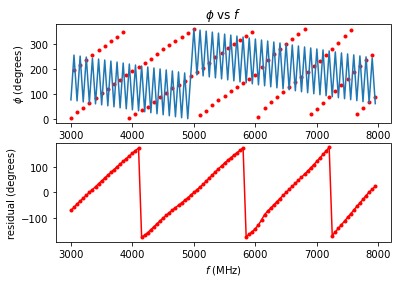

In [208]:
fig, axs = plt.subplots(2,1)

plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (degrees)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(f_v, ff_v[ch], marker='.', linestyle="None",color="Red")
plot.plot(f_v, phase_model(fit.x, f_v))

plot = axs[1]
plot.set_ylabel(r"residual (degrees)")
plot.set_xlabel(r"$f$ (MHz)")

plot.plot(f_v, phase_func(fit.x, ff_v[ch], f_v), marker='.', linestyle="-",color="Red")
#     plot.plot(f0_v, phase_func(x0, (fi_v[ch])), marker='.', linestyle="None",color="Red")


Text(0, 0.5, '$\\phi$ (degree)')

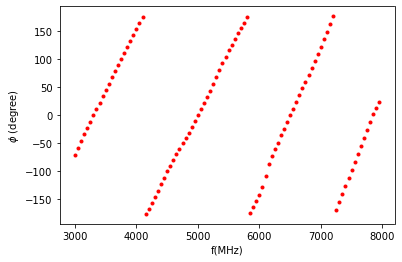

In [204]:
plt.plot(f_v, phase_calibrated, marker='.', linestyle="None",color="Red")
plt.xlabel('f(MHz)')
plt.ylabel(r'$\phi$ (degree)')

### initial guess instead of `least_square` fit

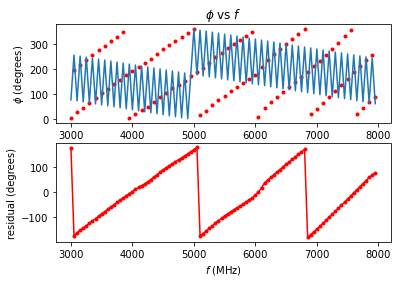

In [207]:
fig, axs = plt.subplots(2,1)

plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (degrees)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(f_v, ff_v[ch], marker='.', linestyle="None",color="Red")
plot.plot(f_v, phase_model(fit.x, f_v))

plot = axs[1]
plot.set_ylabel(r"residual (degrees)")
plot.set_xlabel(r"$f$ (MHz)")

plot.plot(f_v, phase_func([190, 42.53], ff_v[ch], f_v), marker='.', linestyle="-",color="Red")

In [104]:
fit.x

array([195.59442516,  42.53010939])

In [171]:
2*np.pi*0.53

3.330088212805181

In [198]:
x0

array([351.43571664,  42.50519613])